In [1]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import pandas as pd
import math
import pycolmap


In [2]:
def getAUC(errors, threshold_list):
    auc = []

    for threshold in threshold_list:
        auc.append(np.sum(errors < threshold)/len(errors))

    return auc

In [3]:
def plotCDF_all(results, method_names, skip_name = []):
    method_names_ = method_names.copy()
    error_names = ['R Error (deg)', 't Error (cm)', 'f Error (px)', 'Runtime (ms)', 'Iterations', 'Num Inliers']
    
    error_limits = [1, 10, 10, 200, 300, 2000]
    n = len(method_names)

    plt.figure(figsize=(10, 6))
    for i in range(len(error_names)):
        plt.subplot(2, 3, i+1)
        for j in range(n):
            if method_names[j] in skip_name:
                continue
            sns.ecdfplot(results[:,i+j*6])
        plt.xlabel(error_names[i])
        plt.xlim(0, error_limits[i])
        plt.ylabel('CDF')

    for name_ in method_names:
        if name_ in skip_name:
            method_names_.remove(name_)

    plt.legend(method_names_)
    plt.tight_layout()
    plt.show()



In [4]:
def collectErrors(errors, method_names):

    assert len(errors[list(errors.keys())[0]]) == len(method_names)*6

    results = []
    for query_name in errors.keys():
        results.append(errors[query_name])
    results = np.array(results)

    return results

In [5]:
def showErrors(errors, method_names):
    
    top_level_headers = ['R Error (deg)', 't Error (cm)', 'f Error (px)', 'Runtime (ms)', 'Iterations', 'Num Inliers']

    table = np.reshape(errors, (len(method_names), int(errors.shape[0]/len(method_names))))
    df = pd.DataFrame(table, columns=top_level_headers, index=method_names)

    return df

In [6]:
def getAUC(errors, R_idx, t_idx, R_thrs, t_thrs):
    n = errors.shape[0]
    assert len(R_thrs) == len(t_thrs)
    
    auc = []
    for j in range(len(R_thrs)):
        auc_ = 0
        for i in range(n):
            if errors[i,R_idx] < R_thrs[j] and errors[i,t_idx] < t_thrs[j]:
                auc_ += 1
        auc.append(auc_/n)
    return auc

# Dataset statistics

In [8]:
# scene_list = ["festia_out_corridor", "sportunifront", "parakennus_out", "main_campus", 
#     "Kitchen_In", "meetingroom", "night_out", "outcorridor", "parakennus"]
    # , "upstairs"
scene_list = ["festia_out_corridor"]

# larger sequence 0, 1, 3, 9
# scene = scene_list[2]
gt_dirs = Path("/home2/xi5511zh/Xinyue/Datasets/Fisheye_FIORD")
# method_names = ['p3p', 'P4Pfr_LM', 'P4Pfr_HC_pose', 'P4Pfr_HC_depth', 'P3P_sampling_LM', 'P3P_sampling_HC']
# method_names = ['p3p', 'P4Pfr', 'P4Pfr_LM', 'P4Pfr_HC_pose', 'P4Pfr_HC_depth', 'P3P_sampling_LM', 'P3P_sampling_HC', 'p3p_givenf', 'P5Pfr', 'P5Pfr_LM']
method_names = ['recalibrator', 'P4Pfr', 'P4Pfr_LM', 'P5Pfr', 'P5Pfr_LM', 'P4Pfr_HC_pose', 'P4Pfr_HC_depth', 
    'p3p', 'P3P_sampling_LM', 'P3P_sampling_HC', 'p3p_given_gtf', 'p3p_given_anyCalibf1', 'p3p_given_anyCalibf4']

# load results

In [24]:
map_prefix = "covisible80"
threshold = 10.0

In [25]:
results_all = {}
results_overall = []
for scene in scene_list:
    results_dir = gt_dirs / scene / f"processed_{map_prefix}/hloc/RANSACresults_{threshold}.pkl"
    with open(results_dir, 'rb') as f:
        errors = pickle.load(f)
    results = collectErrors(errors, method_names)
    results_all[scene] = results
    results_overall.append(results)
results_overall = np.concatenate(results_overall, axis=0)

In [26]:
# # Define a function to apply the styling
# def highlight_best(s):
#     """Highlights the best value in a Series."""
#     # For 'Num Inliers', the max value is best
#     if s.name == 'Num Inliers':
#         is_best = s == s.max()
#     # For all other columns, the min value is best
#     else:
#         is_best = s == s.min()
#     return ['font-weight: bold' if v else '' for v in is_best]

# Define a function to apply the styling, SKIPPING a list of methods
def highlight_best(s):
    """Highlights the best value in a Series, ignoring a specific list of methods."""
    
    # --- Define the methods you want to exclude from the "best" calculation ---
    methods_to_exclude = ['p3p', 'p3p_given_gtf']
    
    # Create a temporary series that excludes the specified rows
    s_filtered = s[~s.index.isin(methods_to_exclude)]
    
    # For 'Num Inliers', the max value is best
    if s.name == 'Num Inliers':
        best_value = s_filtered.max()
    # For all other columns, the min value is best
    else:
        best_value = s_filtered.min()
        
    # Apply the bold style where the series value matches the best value
    is_best = s == best_value
    return ['font-weight: bold' if v else '' for v in is_best]

In [27]:
medianError = np.median(results_overall, axis=0)
df_median = showErrors(medianError, method_names)
display(df_median.style.apply(highlight_best).format('{:.4f}'))

,R Error (deg),t Error (cm),f Error (px),Runtime (ms),Iterations,Num Inliers
recalibrator,0.0378,0.1972,0.6428,127.2062,279.0000,1835.5000
P4Pfr,0.0424,0.2671,0.4139,82.0271,72.0000,2170.0000
P4Pfr_LM,0.0422,0.2672,0.4057,31.3048,72.0000,2172.5000
P5Pfr,0.0422,0.2671,0.4133,62.8539,100.0000,2170.0000
P5Pfr_LM,0.0424,0.2621,0.4112,30.5403,100.0000,2172.5000
P4Pfr_HC_pose,0.0422,0.2671,0.4123,47.6154,72.0000,2172.5000
P4Pfr_HC_depth,0.0418,0.2607,0.4123,42.2977,72.0000,2172.5000
p3p,0.3110,2.6289,0.0000,9.1736,101.0000,2792.0000
P3P_sampling_LM,0.0422,0.2672,0.4057,34.3954,72.0000,2172.5000
P3P_sampling_HC,0.0422,0.2607,0.4139,69.9491,72.0000,2172.5000


In [28]:
meanError = np.mean(results_overall, axis=0)
df_mean = showErrors(meanError, method_names)
display(df_mean.style.apply(highlight_best).format('{:.4f}'))

,R Error (deg),t Error (cm),f Error (px),Runtime (ms),Iterations,Num Inliers
recalibrator,0.0509,0.2709,0.9470,150.6868,349.3400,1971.1200
P4Pfr,0.0558,0.3079,0.6856,97.9519,89.8600,2348.1200
P4Pfr_LM,0.0557,0.3082,0.6815,35.8151,89.9400,2348.0200
P5Pfr,0.0558,0.3081,0.6865,77.0961,140.6400,2347.8600
P5Pfr_LM,0.0543,0.3045,0.6628,35.1021,141.8800,2347.4400
P4Pfr_HC_pose,0.0556,0.3078,0.6823,53.7415,90.0600,2347.9400
P4Pfr_HC_depth,0.0543,0.3042,0.6621,46.8881,90.4000,2347.5800
p3p,0.4719,4.5215,0.0000,9.5226,101.0000,2997.8800
P3P_sampling_LM,0.0557,0.3082,0.6853,42.1153,89.8600,2348.2000
P3P_sampling_HC,0.0543,0.3044,0.6636,79.1244,90.3600,2347.5800


## AUC (R and t)

In [29]:
# Define a function to apply the styling
def highlight_best2(s):
    """Highlights the best value in a Series."""
    # For 'mean time (ms)', the min value is best
    if s.name == 'mean time (ms)':
        is_best = s == s.min()
    # For all other (AUC) columns, the max value is best
    else:
        is_best = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_best]

In [30]:
R_thr = [1, 1, 2, 5, 5]
t_thr = [1, 2, 5, 5, 10]
f_thr = [1, 2, 5, 10, 50]

AUC = []
for m_idx in range(len(method_names)):
    auc_ = getAUC(results_overall, m_idx*6, m_idx*6+1, R_thr, t_thr)
    AUC.append({'method': method_names[m_idx],
                f"{R_thr[0]}deg, {t_thr[0]}cm": auc_[0]*100,
                f"{R_thr[1]}deg, {t_thr[1]}cm": auc_[1]*100,
                f"{R_thr[2]}deg, {t_thr[2]}cm": auc_[2]*100,
                f"{R_thr[3]}deg, {t_thr[3]}cm": auc_[3]*100,
                f"{R_thr[4]}deg, {t_thr[4]}cm": auc_[4]*100,
                "mean time (ms)": np.mean(results_overall, axis=0)[m_idx*6+3]})
AUC = pd.DataFrame(AUC)
AUC = AUC.set_index('method')
display(AUC.style.apply(highlight_best2).format('{:.2f}'))

,"1deg, 1cm","1deg, 2cm","2deg, 5cm","5deg, 5cm","5deg, 10cm",mean time (ms)
method,,,,,,
recalibrator,98.00,100.00,100.00,100.00,100.00,150.69
P4Pfr,98.00,100.00,100.00,100.00,100.00,97.95
P4Pfr_LM,98.00,100.00,100.00,100.00,100.00,35.82
P5Pfr,98.00,100.00,100.00,100.00,100.00,77.10
P5Pfr_LM,98.00,100.00,100.00,100.00,100.00,35.10
P4Pfr_HC_pose,98.00,100.00,100.00,100.00,100.00,53.74
P4Pfr_HC_depth,98.00,100.00,100.00,100.00,100.00,46.89
p3p,14.00,34.00,76.00,76.00,94.00,9.52
P3P_sampling_LM,98.00,100.00,100.00,100.00,100.00,42.12


## AUC (t and f)

In [31]:
AUC = []
for m_idx in range(len(method_names)):
    auc_ = getAUC(results_overall, m_idx*6+1, m_idx*6+2, t_thr, f_thr)
    AUC.append({'method': method_names[m_idx],
                f"{t_thr[0]}cm, {f_thr[0]}px": auc_[0]*100,
                f"{t_thr[1]}cm, {f_thr[1]}px": auc_[1]*100,
                f"{t_thr[2]}cm, {f_thr[2]}px": auc_[2]*100,
                f"{t_thr[3]}cm, {f_thr[3]}px": auc_[3]*100,
                f"{t_thr[4]}cm, {f_thr[4]}px": auc_[4]*100,
                "mean time (ms)": np.mean(results_overall, axis=0)[m_idx*6+3]})
AUC = pd.DataFrame(AUC)
AUC = AUC.set_index('method')
display(AUC.style.apply(highlight_best2).format('{:.2f}'))

,"1cm, 1px","2cm, 2px","5cm, 5px","5cm, 10px","10cm, 50px",mean time (ms)
method,,,,,,
recalibrator,70.00,88.00,98.00,100.00,100.00,150.69
P4Pfr,82.00,92.00,100.00,100.00,100.00,97.95
P4Pfr_LM,82.00,92.00,100.00,100.00,100.00,35.82
P5Pfr,82.00,92.00,100.00,100.00,100.00,77.10
P5Pfr_LM,82.00,92.00,100.00,100.00,100.00,35.10
P4Pfr_HC_pose,82.00,92.00,100.00,100.00,100.00,53.74
P4Pfr_HC_depth,82.00,92.00,100.00,100.00,100.00,46.89
p3p,14.00,34.00,76.00,76.00,94.00,9.52
P3P_sampling_LM,82.00,92.00,100.00,100.00,100.00,42.12


## Median Table

In [32]:
# for scene in scene_list:
#     results = results_all[scene]
#     display(scene)
#     medianError = np.median(results, axis=0)
#     df_median = showErrors(medianError, method_names)
#     display(df_median)

## Mean Table

In [33]:
# for scene in scene_list:
#     results = results_all[scene]

#     display(scene)
#     meanError = np.mean(results, axis=0)
#     df_mean = showErrors(meanError, method_names)
#     display(df_mean)

# Error CDF

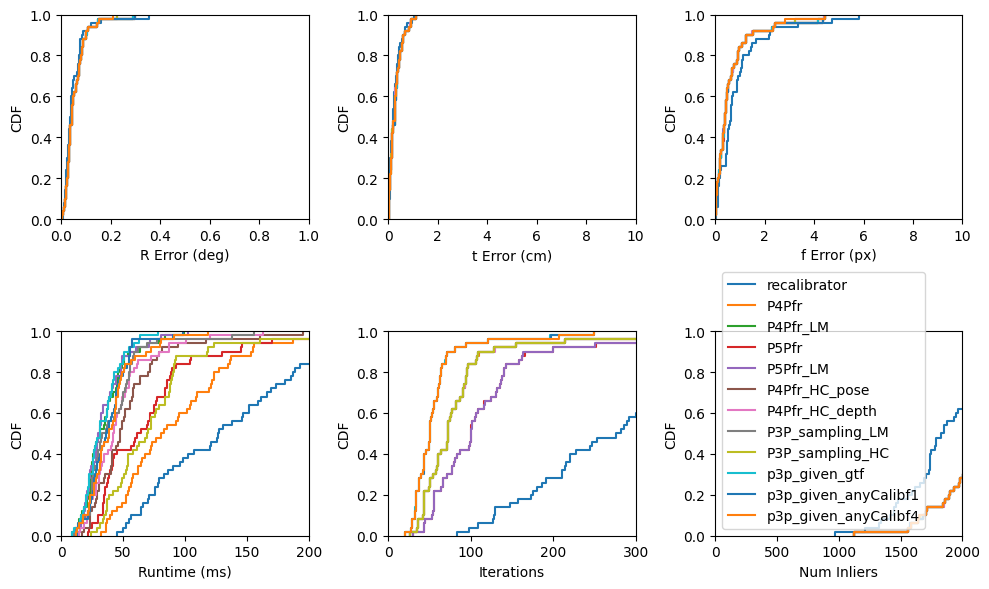

In [34]:
plotCDF_all(results_overall, method_names, 'p3p')

## time boxplot

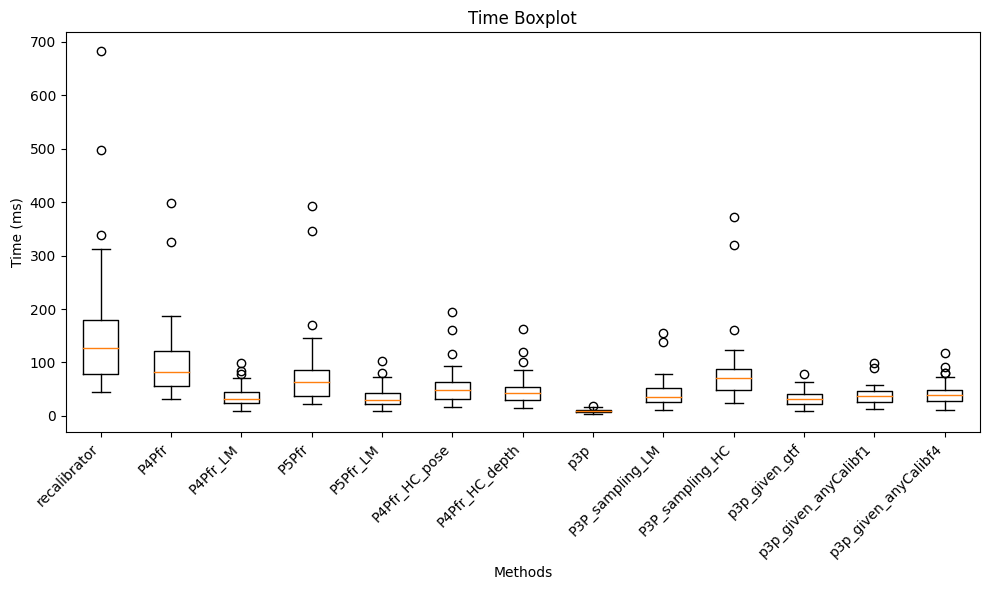

In [35]:
time_idx = [i*6+3 for i in range(len(method_names))]
time_overall = results_overall[:, time_idx]
plt.figure(figsize=(10, 6))
plt.boxplot(time_overall, labels=method_names)
plt.xlabel('Methods')
plt.ylabel('Time (ms)')
plt.title('Time Boxplot')
# plt.ylim(0, 400)
plt.xticks(rotation=45, ha='right')  # Rotate labels 45 degrees and align to the right
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

## iteration boxplot

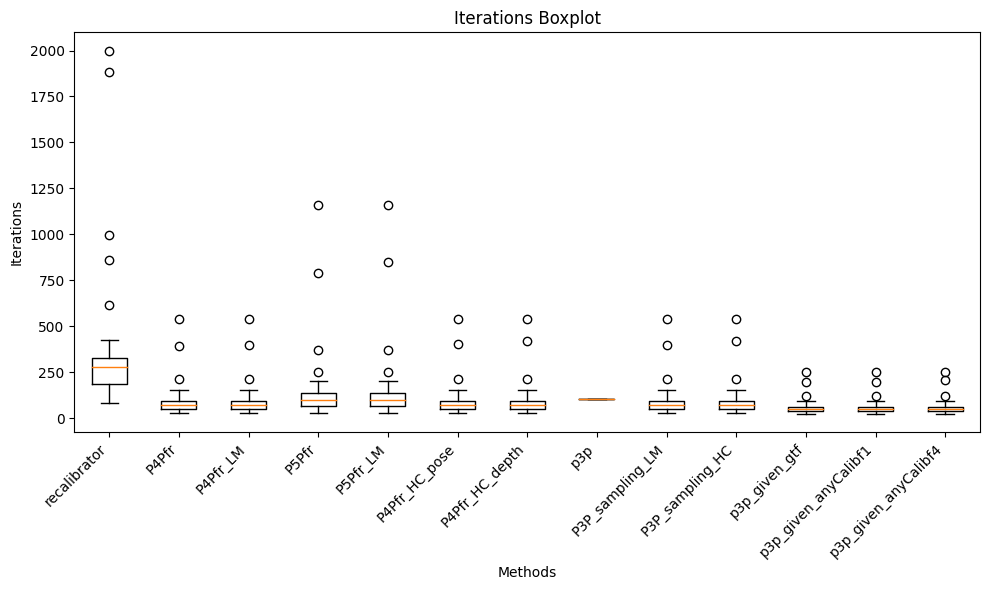

In [36]:
iter_idx = [i*6+4 for i in range(len(method_names))]
iter_overall = results_overall[:, iter_idx]
plt.figure(figsize=(10, 6))
plt.boxplot(iter_overall, labels=method_names)
plt.xlabel('Methods')
plt.ylabel('Iterations')
plt.title('Iterations Boxplot')
# plt.ylim(0, 500)
plt.xticks(rotation=45, ha='right')  # Rotate labels 45 degrees and align to the right
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

# check individual error

In [37]:
query_name_list = list(errors.keys())
query_name = query_name_list[16]

In [38]:
corrs = gt_dirs / scene / "processed_remove_neighbours/Corrs/CorrsDict.pkl"
with open(corrs, 'rb') as f:
    corrs = pickle.load(f)
corrs[query_name]['imageID']


KeyError: 'cam1/IMG_20241224_132536_00_738_fisheye1.jpg'

In [ ]:
query_name = 'cam1/IMG_20250330_115955_00_235_fisheye1.jpg'

In [ ]:
df = showErrors(errors[query_name], method_names)
df

KeyError: 'cam1/IMG_20250330_115955_00_235_fisheye1.jpg'